# 1D convolution and max pool for time-series classification

shape of the train_x:  (450, 270)
train size before splitting:  450
size of train set:  360
size of validation set:  90
size of the test set:  455


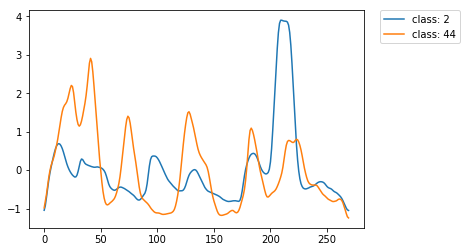

In [2]:
# load the data for time-series
from nnlib.load_time_series import load_data
import pandas as pd
dirname = "50words"
datasets = load_data(dirname)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

from matplotlib import pyplot
pyplot.plot(train_set_x[0], label="class: " + str(train_set_y[0]))
pyplot.plot(train_set_x[1], label="class: " + str(train_set_y[1]))
pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pyplot.show()

In [15]:
# valid convolution
import numpy as np
from scipy import signal
from nnlib.layers import conv_forward_naive_1D

x = np.array([2,1,2,3])
w = np.array([1,2])
b = np.array([0])

x = x.reshape(1,1,len(x))
w = w.reshape(1,1,len(w))

conv_param = {'stride': 1, 'pad': 0}
out, _ = conv_forward_naive_1D(x, w, b, conv_param)
print("conv_forward_naive_1D out: ", out)

scipy_out = signal.correlate(x, w, mode="valid", method="direct")
print("correlate scipy out: ", scipy_out)

conv_forward_naive_1D out:  [[[4. 5. 8.]]]
correlate scipy out:  [[[4 5 8]]]


In [16]:
import numpy as np
from scipy import signal
from nnlib.layers import conv_forward_naive_1D

x = np.array([2,1,2,3])
w = np.array([1,2])
b = np.array([0])

x = x.reshape(1,1,len(x))
w = w.reshape(1,1,len(w))

conv_param = {'stride': 1, 'pad': 1}
out, _ = conv_forward_naive_1D(x, w, b, conv_param)
print("conv_forward_naive_1D out: ", out)

scipy_out = signal.correlate(x, w, mode="full", method="direct")
print("correlate scipy out: ", scipy_out)

conv_forward_naive_1D out:  [[[4. 4. 5. 8. 3.]]]
correlate scipy out:  [[[4 4 5 8 3]]]


In [31]:
import numpy as np
from scipy import signal
from nnlib.layers import conv_forward_naive_1D

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

x_shape = (1, 1, 10)
w_shape = (1, 1, 2)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
# b = np.linspace(-0.1, 0.2, num=w_shape[0])
b = np.zeros(w_shape[0])
conv_param = {'stride': 1, 'pad': 1}
out, _ = conv_forward_naive_1D(x, w, b, conv_param)
print("conv_forward_naive_1D out: ", out)

scipy_out = signal.correlate(x, w, mode="full", method="direct")
print("correlate scipy out: ", scipy_out)

# Compare your output to ours; difference should be around 2e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, scipy_out))

conv_forward_naive_1D out:  [[[-0.03        0.01        0.01666667  0.02333333  0.03
    0.03666667  0.04333333  0.05        0.05666667  0.06333333
   -0.1       ]]]
correlate scipy out:  [[[-0.03        0.01        0.01666667  0.02333333  0.03
    0.03666667  0.04333333  0.05        0.05666667  0.06333333
   -0.1       ]]]
Testing conv_forward_naive
difference:  0.0


# 1D naive convolution for time-series data

In [43]:
from nnlib.layer_utils import conv_relu_forward_naive_1D, conv_relu_backward_naive_1D
from nnlib.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient

np.random.seed(231)
channel = 1
nr_filters = 2 
nr_data = 5 # number of time-series data == batch size
WW = 5 # the width of the filter
W = 10 # the width of the input data

x = np.random.randn(nr_data, channel, W)
w = np.random.randn(nr_filters, channel, WW)
b = np.random.randn(nr_filters,)

stride = 3
pad = 4
conv_param = {'stride': stride, 'pad': pad}
out_conv = np.int(((W + 2 * pad - WW) // stride) + 1)

dout = np.random.randn(nr_data, nr_filters, out_conv)

out, cache = conv_relu_forward_naive_1D(x, w, b, conv_param)
dx, dw, db = conv_relu_backward_naive_1D(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward_naive_1D(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward_naive_1D(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward_naive_1D(x, w, b, conv_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  1.7046892611805446e-11
dw error:  1.6628032573142098e-11
db error:  3.27543579789229e-12


In [44]:
# 1D naive convolution - different stride and padding tested

from nnlib.layer_utils import conv_relu_pool_forward_naive_1D, conv_relu_pool_backward_naive_1D
np.random.seed(231)
channel = 1
nr_filters = 2
nr_data = 5
WW = 5
W = 10

x = np.random.randn(nr_data, channel, W)
w = np.random.randn(nr_filters, channel, WW)
b = np.random.randn(nr_filters,)

stride = 1
pad = 2
conv_param = {'stride': stride, 'pad': pad}
out_conv = np.int(((W + 2 * pad - WW) // stride) + 1)
print("out_conv: ", out_conv)

pool_width = 2
pool_stride = 2
pool_param = {'pool_width': pool_width, 'stride': pool_stride}
out_pool = np.int(((out_conv - pool_width) // pool_stride) + 1)
print("out_pool: ", out_pool)

dout = np.random.randn(nr_data, nr_filters, out_pool)

out, cache = conv_relu_pool_forward_naive_1D(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward_naive_1D(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward_naive_1D(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward_naive_1D(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward_naive_1D(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))


out_conv:  10
out_pool:  5
Testing conv_relu_pool
dx error:  8.013602017060373e-10
dw error:  8.309786420951745e-11
db error:  3.2754875679135037e-12


In [46]:
# 1D naive max pool - forward and backward

from nnlib.layers import max_pool_forward_naive_1D, max_pool_backward_naive_1D
np.random.seed(231)
channel = 1
nr_filters = 1
nr_data = 1
WW = 5
W = 10

x = np.random.randn(nr_data, channel, W)
x[0,0,:] = np.array([1,2,3,4,5,6,7,8,9,10])
#x[0,0,:] = [1,2,3,4,5,6,7,8,9,10]

pool_width = 5
pool_stride = 3
pool_param = {'pool_width': pool_width, 'stride': pool_stride}
out_pool = np.int(((W - pool_width) // pool_stride) + 1)
print("out_pool dimension: ", out_pool)

dout = np.random.randn(nr_data, channel, out_pool)
print("dout: ", dout)

out, cache = max_pool_forward_naive_1D(x, pool_param)
print("out from max_pool: ", out)

dx = max_pool_backward_naive_1D(dout, cache)
print("dx: ", dx)

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive_1D(x, pool_param)[0], x, dout)

print('Testing max_pool_naive_1D')
print('dx error: ', rel_error(dx_num, dx))

out_pool dimension:  2
dout:  [[[-0.34227539  0.29490764]]]
out from max_pool:  [[[5. 8.]]]
dx:  [[[ 0.          0.          0.          0.         -0.34227539
    0.          0.          0.29490764  0.          0.        ]]]
Testing max_pool_naive_1D
dx error:  1.892892533819966e-11


In [41]:
# As usual, a bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from nnlib.classifiers.cnn import *
from nnlib.data_utils import get_CIFAR10_data
from nnlib.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from nnlib.layers import *
from nnlib.fast_layers import *
from nnlib.solver import Solver

from nnlib.classifiers.cnn_time_series_1D import ThreeLayerConvNetTimeSeries
np.random.seed(231)

#print(valid_set_x.shape)
#print(valid_set_x.reshape(valid_set_x.shape[0], 1, 1, -1).shape)
#print(valid_set_x.reshape(len(valid_set_x), 1, 1, -1).shape)

def reshapeTS(x):
    """
    Reshape the time-series data to have only a single dimension for 
    channels and height. Move the time-series value to the width dimension.
    """
    return x.reshape(x.shape[0], 1, 1, -1)
    
num_train = 450
small_data = {
  'X_train': reshapeTS(train_set_x[:num_train]),
  'y_train': reshapeTS(train_set_y[:num_train]),
  'X_val': reshapeTS(valid_set_x),
  'y_val': reshapeTS(valid_set_y)
}

time_dimension = valid_set_x.shape[1]
print("time dimension: ", time_dimension)
model = ThreeLayerConvNetTimeSeries(input_dim = (1,1,time_dimension),
                          num_filters = 32,
                          filter_size = 3,
                          filter_channels = 1,
                          hidden_dim = 100,
                          num_classes = 50,
                          weight_scale = 1e-2,
                          pad_convolution = 2)

solver = Solver(model, small_data,
                num_epochs=30, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=1)
solver.train()

time dimension:  270


ValueError: too many values to unpack (expected 3)